In [2]:
#%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, float64, complex128, int64, types
%matplotlib inline

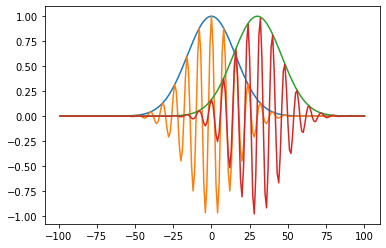

In [3]:
a = np.linspace(-99,100,200)
a1 = np.linspace(-99, 100, 200)
b1 = np.exp(-(a1-30)**2/500.)
b = np.exp(-a**2/500.)
plt.plot(a, b)
phase = 2*np.pi*a/8
phase1 = 2*np.pi*a1/8+np.pi/20
plt.plot(a, b*np.cos(phase))

plt.plot(a1, b1)
plt.plot(a1, b1*np.cos(phase1))

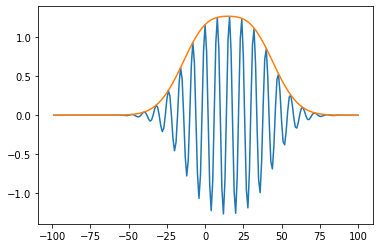

In [4]:


plt.plot(a, b*np.cos(phase) + b1*np.cos(phase1))
#plt.plot(a1, np.exp())
plt.plot(a, np.sqrt(b1**2 + b**2 +2*b1*b*np.cos(phase1-phase)))

In [9]:
from matplotlib.patches import Circle


from collections import namedtuple as nt
mode_params=nt("mode_params", "a0 m p Mp w0")

from scipy.special import hermite, genlaguerre


def LG_mode(mode_params, tau, r, phi, z):
    a0=mode_params.a0
    m=mode_params.m  # mode number x
    p=mode_params.p  # mode number y
    Mp=mode_params.Mp 
        
    w0=mode_params.w0
    Lpm=genlaguerre(p,np.abs(m))
    
    ZR = Mp*w0**2/2
    
    w = w0*np.sqrt(1+z**2/ZR**2)
    chi = np.arctan(z/ZR)
    
    toret = 1/np.sqrt(w)*(r*np.sqrt(2)/w)**np.abs(m)*np.exp(-r**2/w**2)*Lpm(2*r**2/w**2)
    
    toret = toret*np.exp(-1j*r**2*z/2/(ZR**2+z**2))
    
    toret = toret*np.exp(1j*m*phi) * np.exp(-z**2/2/tau**2)*np.exp(1j*Mp*z)
    
    toret = a0*toret*np.exp(-1j*(2*p+np.abs(m)+1)*chi)
    
    return toret



In [112]:
@jit(types.Tuple((complex128[:,:,:], 
                  float64[:,:,:], 
                  int64, 
                  int64))
     (int64, 
      int64, 
      float64, 
      float64, 
      float64, 
      float64, 
      float64[:,:,:], 
      float64[:,:,:], 
      float64[:,:,:]), cache=True, nopython=True, parallel=True)
def LG_mode_accelerated(mode_params_m, 
                        mode_params_p, 
                        mode_params_Mp, 
                        mode_params_w0, 
                        mode_params_a0, tau, r, phi, z):
    a0 = mode_params_a0
    m = mode_params_m  # mode number x
    p = mode_params_p  # mode number y
    Mp = mode_params_Mp
    w0 = mode_params_w0
    
    #Lpm=genlaguerre(p,np.abs(m))

    ZR = Mp*w0**2/2
    ZR_sq = np.square(ZR)
    r_sq = np.square(r)
    z_sq = np.square(z)
    
    w = w0*np.sqrt(1+z_sq/ZR_sq)
    w_sq = np.square(w)
    chi = np.arctan(z/ZR)
    
    
    #toret = 1/np.sqrt(w)*(r*np.sqrt(2)/w)**np.abs(m)
    toret = (r*np.sqrt(2)/w)**np.abs(m)

    exp_factor = np.exp(-1j*r_sq*z/2/(ZR_sq+z_sq) + 1j*m*phi -z_sq/2/tau**2 + \
                        1j*Mp*z -1j*(2*p+np.abs(m)+1)*chi-r_sq/w_sq)
    toret = toret * exp_factor
    
    return a0*toret, 2*r_sq/w_sq, p, m

In [113]:
def LG_mode_fast(mode_params, tau, r, phi, z):
    mode, arg, p,m = LG_mode_accelerated(mode_params.m, 
                                     mode_params.p, 
                                     mode_params.Mp, 
                                     mode_params.w0, 
                                     mode_params.a0, tau, r, phi, z)
    Lpm = genlaguerre(p, np.abs(m))
    mode = mode * Lpm(arg)
    return mode

In [313]:
# 3d Laguerre-Gaussian



mode_1 = mode_params(3., 1, 0, 1., 3.**2*np.pi)
mode_2 = mode_params(3., 2, 0, 1., 3.**2*np.pi)

xmin=-10
xmax=10
ymin=-10
ymax=10
zmin=-15
zmax=15

nofxs = 60
nofys = 60
nofzs = 2400

xx = np.linspace(xmin*2*np.pi, xmax*2*np.pi, nofxs)
yy = np.linspace(ymin*2*np.pi, ymax*2*np.pi, nofys)

#rho = linspace(0, )
zz = np.linspace(zmin*2*np.pi, zmax*2*np.pi, nofzs)

#x,y,z=meshgrid(xx,yy,zz)
x,y,z = np.meshgrid(xx,yy,zz, indexing='xy')

In [314]:


r = np.sqrt(x**2+y**2)

xiy = x + 1j*y
phi = np.angle(xiy)

tau = 4*2*np.pi
delay = -2*tau

LG_mode_1 = LG_mode_fast(mode_1, tau, r, phi, z-delay/2)
field_x = np.abs(LG_mode_1) * np.cos(np.angle(LG_mode_1))

LG_mode_2 = LG_mode_fast(mode_2, tau, r, phi, z+delay/2)
field_x = field_x + np.abs(LG_mode_2) * np.cos(np.angle(LG_mode_2))

envelope1 = np.abs(LG_mode_1)
envelope2 = np.abs(LG_mode_2)

#np.sqrt(b1**2 + b**2 +2*b1*b*np.cos(phase1-phase))

full_envelope = np.sqrt(envelope1**2 + \
                envelope2**2 + 2*envelope1*envelope2*\
                np.cos(np.angle(LG_mode_2)-np.angle(LG_mode_1)))

#full_envelope = np.sqrt(envelope1**2 + \
#                envelope2**2)

# now i have field_x numerically representing incoming
# how to add reflection


# for every x,y:
# find a (envelope)
# refl_field = LG_mode_envelope * cos(...z+zmirror)
# interp
# output: interped array of fields including retarded time

zmirror = full_envelope/np.sqrt(1+full_envelope ** 2) \
          * (np.cos(np.angle(LG_mode_1)))**2

zmirror = 1./(1+full_envelope ** 2)*(envelope1*np.cos(np.angle(LG_mode_1))+envelope2*np.cos(np.angle(LG_mode_2)))**2

refl_field = envelope1 * np.cos(np.angle(LG_mode(mode_1, tau, r, phi, z-delay/2+zmirror)))
# refl_field= envelope1  add sources 

zd = z-zmirror

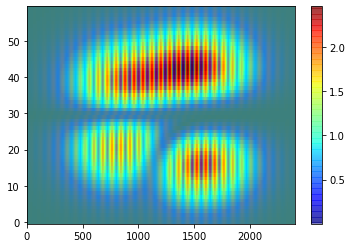

In [315]:
plt.imshow(np.real(field_x[30,:,:]), aspect='auto', origin='lower', cmap=plt.jet())
plt.imshow(full_envelope[30,:,:], aspect='auto', origin='lower', alpha=0.5)

plt.colorbar()

In [218]:
np.max(field_x)
#genlaguerre(0, np.abs(0))

2.9891999014015256

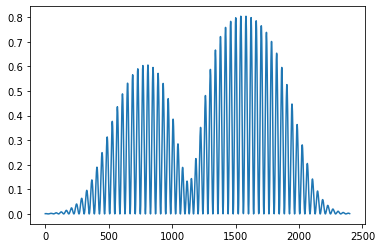

In [317]:
#plt.plot(np.real(field_x[30,30,:]))
#plt.plot(full_envelope[30,30,:]**2)
plt.plot(zmirror[-20,20,:])

In [8]:
%%timeit
LG_mode_fast(mode_1, tau, r, phi, z-delay/2)

125 ms ± 6.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%%timeit
LG_mode(mode_1, tau, r, phi, z-delay/2)

413 ms ± 4.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
np.isclose(LG_mode(mode_1, tau, r, phi, z-delay/2),LG_mode_fast(mode_1, tau, r, phi, z-delay/2)).all()

True

In [175]:
def get_interp_field_simple(z, zd, refl_field):
    refl_field_interp = np.zeros_like(refl_field)
    for i in range(z.shape[0]):
        for j in range(z.shape[1]):
            refl_field_interp[i,j,:] = np.interp(z[i,j,:], zd[i,j,:], refl_field[i,j,:])
    return refl_field_interp

In [ ]:
%%timeit
refl_field_interp_simple = get_interp_field_simple(z,zd,refl_field)

In [318]:
refl_field_interp_simple = get_interp_field_simple(z,zd,refl_field)

(-3, 3)

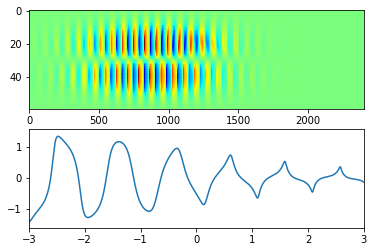

In [320]:
plt.subplot(211)
plt.imshow(refl_field_interp_simple[30,:,:], aspect='auto')
plt.subplot(212)
plt.plot(zz/2/np.pi, refl_field_interp_simple[-20,20,:])
plt.xlim(-3,3)

In [ ]:
plt.plot(zz/2/np.pi, field_x[30,30,:])

from pyevtk.hl import pointsToVTK
from pyevtk.hl import gridToVTK

gridToVTK("./test_potential", x/np.amax(x), y/np.amax(y), z/np.amax(z), pointData = {"field_x" : field_x})

filename='./test_field'
gridToVTK(filename, x/np.amax(x), y/np.amax(y), z/np.amax(z), pointData = {"field_x" : field_x})

# Now load test_potential.vts in Paraview

In [ ]:
plt.plot((zmirror - z)[30,30,290:310], range(290,310))

In [321]:
filt = np.fft.fft(refl_field_interp_simple, axis=2)
freq = np.fft.fftfreq(len(refl_field_interp_simple[1,1,:]), d=zz[1]-zz[0])


(0, 42)

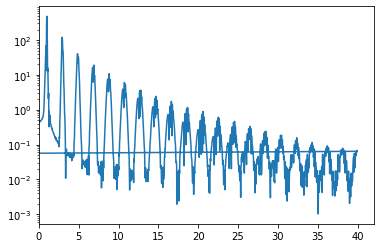

In [322]:
plt.semilogy(freq*2*np.pi, np.abs(filt[20,20,:]))
plt.xlim(0,42)

(0, 21)

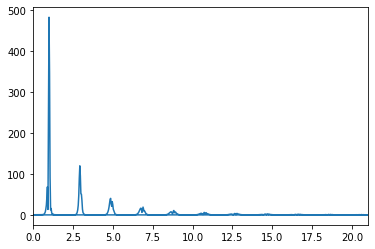

In [323]:
plt.plot(freq*2*np.pi, np.abs(filt[20,20,:]))
plt.xlim(0,21)

In [325]:
filter_center_freq = 3.0 # in laser frequencies
filter_width = 0.5 # in laser frequencies

filt_func = np.exp(-(freq*2*np.pi-filter_center_freq)**100/(filter_width)**100)
filt_func = filt_func+np.exp(-(freq*2*np.pi+filter_center_freq)**100/(filter_width)**100)

filt=filt*filt_func

refl_filt = np.fft.ifft(filt, axis=2)

(-30, 30)

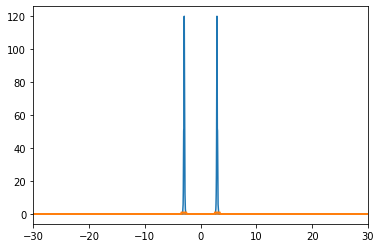

In [326]:
plt.plot(freq*2*np.pi, np.abs(filt[20,20,:]))

plt.plot(freq*2*np.pi, filt_func)
plt.xlim(-30,30)

(-1, 1)

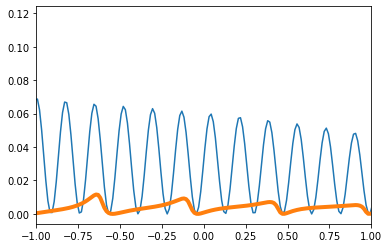

In [327]:
plt.plot(zz/2/np.pi, np.real(refl_filt[20,20,:])**2)
plt.plot(zz/2/np.pi, 0.01*np.abs(refl_field_interp_simple[20,20,:])**2, lw=4)
plt.xlim(-1,1)

In [256]:
1.5*15

22.5

In [328]:
from ipywidgets import interact

In [308]:
@interact(n=(0,nofzs-1,2))
def Plotter
(n=0):
    plt.imshow(np.real(refl_filt[:,:,n]))
    #plt.imshow(field_x[:,:,n])
    #clim(0,0.1)
    tosave = '%03d_field.png' % n
    plt.savefig(tosave, dpi=100)

interactive(children=(IntSlider(value=0, description='n', max=2399, step=2), Output()), _dom_classes=('widget-…

In [ ]:
field_x_fft=fft.fft(field_x)

field_x_fft.shape
figure()
plot(abs(field_x_fft[40,40,:]))
xlim(0,25)

figure()
subplot(121)
title('Absolute value')
imshow(abs(field_x_fft[:,:,10]))

subplot(122)
title('Angle')
imshow(angle(field_x_fft[:,:,10]))

In [ ]:
# 3d Laguerre-Gaussian

mode_1 = mode_params(1.  ,    1 , 4, 1., 3.*2*pi)
mode_2 = mode_params(0.01,    10, 0, 1., 3.*2*pi)
mode_3 = mode_params(0.2 ,    5 , 0, 1., 3.*2*pi)
mode_4 = mode_params(0.  ,    1 , 0, 1., 3.*2*pi)

xmin=-10
xmax=20
ymin=-10
ymax=10
zmin=-5
zmax=5

nofxs = 200
nofys = 100
nofzs = 200

xx=linspace(xmin*2*pi, xmax*2*pi, nofxs)
yy=linspace(ymin*2*pi, ymax*2*pi, nofys)

rho = linspace(0, xmax*2*pi, nofxs)
phi = linspace(0, 2*pi, nofys)
zz=linspace(zmin*2*pi, zmax*2*pi, nofzs)

rho,phi,z=meshgrid(rho,phi,zz, indexing='xy')

#x,y,z=meshgrid(xx,yy,zz)
#x,y,z=meshgrid(xx,yy,zz, indexing='xy')

#r=sqrt(x**2+y**2)

#xiy = x+1j*y
#phi=angle(xiy)

field_x = abs(LG_mode(mode_1, 10, rho, phi, z))*cos(angle(LG_mode(mode_1, 10, rho, phi, z)))
field_x = field_x + abs(LG_mode(mode_2, 10, rho, phi, z))*cos(angle(LG_mode(mode_2, 10, rho, phi, z)))
field_x = field_x + abs(LG_mode(mode_3, 10, rho, phi, z))*cos(angle(LG_mode(mode_3, 10, rho, phi, z)))
field_x = field_x + abs(LG_mode(mode_4, 10, rho, phi, z))*cos(angle(LG_mode(mode_4, 10, rho, phi, z)))


plot(field_x[40,40,:])


#from pyevtk.hl import pointsToVTK
#from pyevtk.hl import gridToVTK

#gridToVTK("./test_potential", x/amax(x), y/amax(y), z/amax(z), pointData = {"field_x" : field_x})

#filename='./test_field'
#gridToVTK(filename, x/amax(x), y/amax(y), z/amax(z), pointData = {"field_x" : field_x})

# Now load test_potential.vts in Paraview

In [ ]:
@interact(n=(0,200))
def Plotter(n=0):
    
    figure()
    fig,ax = plt.subplots(subplot_kw=dict(projection='polar'))
    fig3=ax.pcolormesh(phi[:,:,n],rho[:,:,n], abs(field_x[:,:,n]))


In [ ]:
field_spec=fft.fft(field_x, axis=2)
w=fft.fftfreq(shape(field_x)[2], d=zz[1]-zz[0])*2*pi
plot(w, abs(field_spec[50,50,:]))
dw=w[1]-w[0]

In [ ]:
@interact(n=(0,200))
def Plotter(n=10):
    
    
    figure(figsize=(15,10))
    #fig,ax = plt.subplots(subplot_kw=dict(projection='polar'))
    subplot(121, projection='polar')
    pcolormesh(phi[:,:,n],rho[:,:,n], abs(field_spec[:,:,n]))
    title(str(n*dw))
    
    #fig,ax = plt.subplots(subplot_kw=dict(projection='polar'))
    subplot(122, projection='polar')
    pcolormesh(phi[:,:,n],rho[:,:,n], angle(field_spec[:,:,n]))
    #title(str(n*dw))

In [ ]:
to_phi_fft = field_spec[:,:,10]
#to_phi_fft.shape
phispec = fft.fft(to_phi_fft, axis=0)
rhospec = fft.fft(to_phi_fft, axis=1)
figure()
semilogy(abs(phispec[:, 40]), '*-')
xlim(0,20)

figure()
plot(abs(rhospec[50, :]), '.-')
xlim(0,40)
#subplot(111, projection='polar')
#pcolormesh(phi[:,:,10], rho[:,:,10], abs(phispec))

#imshow(log10(abs(phispec)), origin='lower', aspect='auto')

In [ ]:
mode_1=mode_params(1, 3, 0, 2., 3.**2*pi)

xmin=-20
xmax=20
ymin=-20
ymax=20

nofxs = 1000
nofys = 1000

xx=linspace(xmin*2*pi, xmax*2*pi, nofxs)
print(len(xx/2/pi))
yy=linspace(ymin*2*pi, ymax*2*pi, nofys)

x,y=meshgrid(xx,yy)

r=sqrt(x**2+y**2)

xiy = x+1j*y
phi=angle(xiy)

field_x = real(LG_mode(mode_1, 10, r, phi, -100))
field_y = imag(LG_mode(mode_1, 10, r, phi, -100))

print(r.shape)

figure(figsize=(8,8))
fig1 = imshow(angle(field_y), origin='lower', extent=[xmin, xmax, ymin, ymax])
plt.colorbar(fig1,fraction=0.02, pad=0.04)
#c1=Circle((0,0), radius=5, color='w', fill=False)
#plot(0,0, 'wo')
#ax=gca()
#ax.add_artist(c1)

#figure()
#imshow(field.imag)

figure(figsize=(8,8))
imshow(field_x,origin='lower')
colorbar()

In [ ]:
phase = angle(field)
print(shape(phase))


rhorho = np.sqrt((x)**2 + (y)**2)
phiphi = -angle((y)*1j+(xx))
print(shape(rhorho))

figure()
plt.scatter(rhorho.flatten(),phiphi.flatten(),c=phase.flatten(),lw=0,s=3)
#plt.scatter(rho,phi,c=Ex_3D_t,vmin=-2,vmax=2.0,lw=0,s=2)

xlim(0,120)
xlabel('rho')
ylabel('phi')

Rho = linspace(0,120,nofxs)
Phi = linspace(-pi,pi,nofys)
[RhoRho,PhiPhi]=meshgrid(Rho,Phi)

rho_1D = reshape(rhorho,(nofxs * nofys))
phi_1D = reshape(phiphi,(nofxs * nofys))
points = zeros((nofxs * nofys,2))
values = zeros((nofxs * nofys,1))
points[:,0] = rho_1D
points[:,1] = phi_1D
phase_1D = reshape(phase,(nofxs * nofys))

from scipy.interpolate import griddata

values = phase_1D
grid_z = griddata(points, values, (RhoRho, PhiPhi), method='nearest')

figure()
plt.imshow(grid_z,origin='lower',aspect='auto',vmin=-pi,vmax=pi)
colorbar()
#plt.scatter(RhoRho.flatten(),PhiPhi.flatten(),c=grid_z.flatten(),lw=0,s=3)
#xlim(0,120)
#ylim(-pi,pi)

figure()
plot(grid_z[:,50])



In [ ]:
theta=30.0*pi/180
pulse = exp(-(x**2)/2/30**2)*exp(-(y**2)/2/30**2)*sin(0.0-x*cos(theta)-y*sin(theta))

#xprime = x*cos(theta)+y*sin(theta)
#yprime = -x*sin(theta)+y*cos(theta)



#pulse = exp(-(xprime**2)/2/50**2)*sin(0.0-xprime-yprime)
#pulse = pulse * exp(-(yprime**2)/2/50**2)



imshow(pulse)

In [ ]:
sp=fft.fft2(pulse)
kxx=fft.fftfreq(len(pulse), d=xx[1]-xx[0])
kyy=fft.fftfreq(len(pulse), d=yy[1]-yy[0])
kx,ky=meshgrid(kxx,kyy)

In [ ]:
pcolormesh(kx*2*pi,ky*2*pi, log(abs(sp)))
colorbar()
vlines(0,-15,15)
hlines(0, -15, 15)
xlim(-2,2)
ylim(-2,2)

In [ ]:
complex_k = kx+1j*ky

pcolormesh(2*pi*sqrt(kx**2+ky**2), angle(complex_k)*180/pi, log(abs(sp)))

xlim(0,2)

ylim(-60,60)

xlabel(r'$\omega$', fontsize=20)
ylabel(r'$\theta$', fontsize=20)

In [ ]:
mode_1=mode_params(0.4, 10, 0, 1., 0., 3.**2*pi)

xmin=-20
xmax=20
ymin=-20
ymax=20
zmin=-10
zmax=10


xx=linspace(xmin*2*pi, xmax*2*pi, 300)
yy=linspace(ymin*2*pi, ymax*2*pi, 300)
zz=linspace(zmin*2*pi, zmax*2*pi, 100)

x,y,z=meshgrid(xx,yy, zz)

r=sqrt(x**2+y**2)

xiy = x+1j*y
phi=angle(xiy)

field = LG_mode(mode_1, 0, r, phi, z)

print(r.shape)

figure(figsize=(8,8))
imshow(imag(field), origin='lower', extent=[xmin, xmax, ymin, ymax])
c1=Circle((0,0), radius=5, color='w', fill=False)
plot(0,0, 'wo')
ax=gca()
ax.add_artist(c1)

#figure()
#imshow(field.imag)

figure(figsize=(8,8))
imshow(abs(field)**2)

In [ ]:
imshow(real(field[:,:,45]), aspect='auto')
colorbar()

In [ ]:
ddlx = linspace(0,20,200)
ddly = linspace(0,30,300)

ddlxx,ddlyy =meshgrid(ddlx,ddly)

ddlvalue = ddlxx**2+ddlyy**2

pcolormesh(ddlxx,ddlyy,ddlvalue,cmap='jet')
colorbar()


In [ ]:
engMax[n]= sqrt(mass*mass+momMax[n]*momMax[n])-mass;
